In [1]:
import json
from common.utils import numseq2bytes, seq2num
from data.data import Sequence
from graph.graph import add_to_dict, get_kmer_count_from_sequences

In [2]:
import pyfastx

In [3]:
fastq = pyfastx.Fastq("../input/all_data/GCA_027944815.1_ASM2794481v1_genomic/SRR23044223_1.fastq")

In [4]:
read_file = "../input/all_data/GCA_027944815.1_ASM2794481v1_genomic/gene_calls_with_gene_filtering.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)

In [11]:
read_name = list(read_data.keys())[4]

Bio.SeqRecord.SeqRecord

In [15]:
from Bio.SeqRecord import SeqRecord, Seq

In [20]:
s_read = fastq[read_name]

In [23]:
s = s_read.seq[10:50]

In [25]:
SeqRecord(Seq(s),id=read_name,name=read_name, description=read_name)

SeqRecord(seq=Seq('GGTTTTTGGTGCTGACGCCGCCAGCGAGCAAAGCGTTCTG'), id='SRR23044223.5', name='SRR23044223.5', description='SRR23044223.5', dbxrefs=[])

In [16]:
SeqRecord(Seq(s.seq))

SeqRecord(seq=Seq('ACACCTGTATGGTTTTTGGTGCTGACGCCGCCAGCGAGCAAAGCGTTCTGGCGT...CCG'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [9]:
from Bio import SeqIO

In [8]:
s[0:10]

TypeError: 'Read' object is not subscriptable

In [7]:
pyfastx.reverse_complement(s.seq)

'CGGGGATAAACCGTGCGGCGCTCGACGCGGCACGCAGTCGGGCACAGTGTTCCCCGCGCCAGCGGGGATAAACCGCAGGTCGACCGACTGGAGGCGGAGATTGTCGGGTGTTCCCGCGCCAGCGGGGATAAACCGTGTTGTTTTTCTGCCGGATTAACGCGGTGTGAGTGTTCCCCGCGCCAGCGGGGATAAACCGTTGTCGGGCTTGTTCGGCGCGGGTTGTTAACTGTGTTCCCGCGCCAGCGGGGATAAACCGCCAGCGCCGTGGCTGCGATCGCCGACACTGGCGAAGGACTTGCTCGTGTGGTTAAAGCCGTGTTCCCCGCGTCGATAAATCTCGACGCACTGGATGCGATGATGGACATCACTTTGGAGTTCCCTGCCTGCGGTAGAACTCCCAGCTCTCATTTTCAAACCCATCAAGACGCCTTCGCCAGCTCTTTCACCAGCGGTAGCATTATCCGTATAACATCACGGCAGCGACGTTCTATTCTTCCAGGAAGCGCCTTATCAATATGTTGTTGATTAATAAGCCTGACATCGTGCCAGCTTGTTCCCGCAGGGAAGGCGGCGGTTTTTGCACGTTGCTGATAGCCATCCTTATTCCAAGATTCCAGTTAGTTGCCTCCACCGAAAGTACCGCAATACCGGCTTTGTCAAAAACTTCCGCGTCGTTACAGCACCCGGTACCCTTCGGATAATTTTTATTCAAAACCCGGATTGGTCGTTGCGGCAATTCCATGACTACGCGCAATTGCCAGCGCCCTGTCGCGCGTTAATTTCCCTTACTGCTTCAGGGGTTTTTAAATCGCTGTTGAACACAATTTATCGCCAACAATTAAGTTATCGAGATTAATCACCAGCAGCGTATTTTTCGGTGTCACTCATCCGCTTGAGTAAATTCTCAGCACCTAATTTCCCTTCCTCTTCACCACTGGTCGCCACAAATCGAATACCATACTCGGTAGTGTATTTTTTCAGGCGTTCTGCCAGTTCCAG

In [19]:
l=[]
for name,seq,qual in fastq:
    l.append(len(seq))

TypeError: cannot unpack non-iterable Read object

In [8]:
print(len(l))

0


In [10]:
fastq_io = SeqIO.to_dict(SeqIO.parse("../input/all_data/GCA_027944815.1_ASM2794481v1_genomic/SRR23044223_1.fastq","fastq"))

In [49]:
read_file = "../input/all_data/GCA_027944875.1_ASM2794487v1_genomic/gene_calls_with_gene_filtering.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
blocks2reads = {}
for k,g in read_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],k)
blocks = list(blocks2reads.keys())
blocks.sort()

alphabet = [("+"+p1,"-"+p1) for p1 in blocks]
bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})
l_alphabet = len(alphabet)
if l_alphabet < 2**7:
    Sequence.n_b = 1
elif l_alphabet < 2**15:
    Sequence.n_b = 2
elif l_alphabet < 2**31:
    Sequence.n_b = 4
else:
    Sequence.n_b = 8
Sequence.bi_alphabet = bi_alphabet

read_data_trimmed = read_data.values()
read_seqs = [Sequence(i, numseq2bytes(seq2num(seq,Sequence.bi_alphabet), Sequence.n_b), 1) for i,seq in enumerate(read_data_trimmed)]

subseq = read_seqs[:]


In [108]:
k=2
kmers = get_kmer_count_from_sequences(subseq, k=k, cyclic=False)

_ = [kmer.compute_abundance('reads') for kmer in kmers]
kmers.compute_order()

In [109]:
kmer_dict = {kmer:kmer.order for kmer in kmers}

In [110]:
import numpy as np

In [111]:
a = [set() for _ in range(len(subseq))]

In [112]:
from common.utils import rev_comp
from data.data import Kmer

In [113]:
for kmer in kmer_dict:
    print(kmer.seq)
    break

b'\x02\x18\x03\xd3'


In [114]:
print(k)

2


In [115]:
for i,sequence in enumerate(subseq):
    length = len(sequence.seq)
    kb = k*sequence.n_b
    for j in range(0, length-kb+1, sequence.n_b):
        bkmer = sequence.seq[j:j + kb]
        n = len(bkmer)
        kmer = Kmer(len(kmers),bkmer,0)
        a[i].add(kmer)
a = [aa for aa in a if len(aa)>0]

In [131]:
d = np.zeros((len(subseq),len(subseq)))
print(d.shape)
for i,a1 in enumerate(a):
    for j,a2 in enumerate(a[i:]):
        v = len(a1.intersection(a2))
        d[i,j]=v
        d[j,i]=v


(14652, 14652)


In [132]:
import matplotlib.pyplot as plt

In [133]:
len(a[0])

15

In [134]:
d_list = [dd for dd in d.flatten() if dd>0]

In [135]:
from sklearn.cluster import DBSCAN

In [142]:
dbscan = DBSCAN(eps=100,metric="precomputed")

In [143]:
dbscan.fit(d)

DBSCAN(eps=100, metric='precomputed')

In [144]:
dbscan.labels_.max()

0

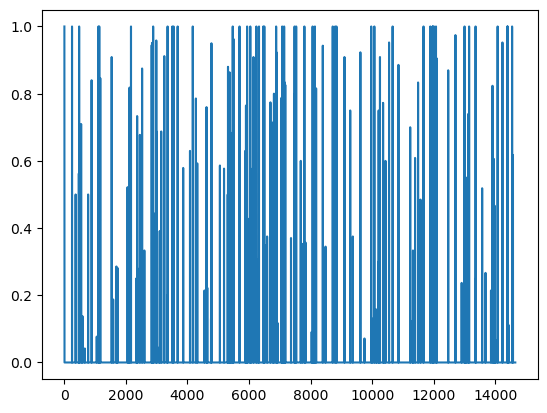

In [130]:
plt.plot(d[5])

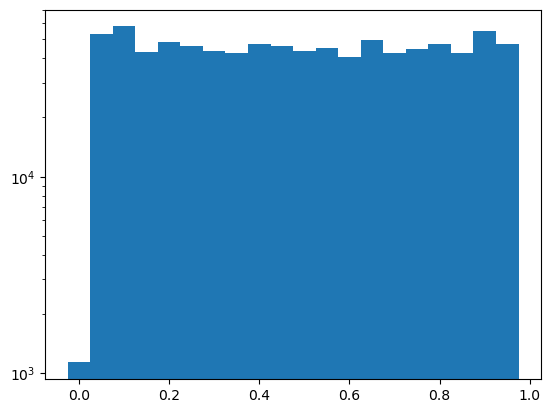

In [124]:
plt.hist(d_list,bins=np.arange(0,1.05,0.05)-0.025)
plt.yscale("log")